In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [5]:
end = date.today()
start = date(end.year - 20, end.month, end.day)
stock_symbol = 'GOOG'
data = yf.download(stock_symbol, start, end)

[*********************100%%**********************]  1 of 1 completed


In [6]:
data.reset_index(inplace=True)

In [7]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512
...,...,...,...,...,...,...,...
4981,2024-06-04,174.449997,175.190002,173.220001,175.130005,174.930939,14066600
4982,2024-06-05,176.535004,177.970001,175.289993,177.070007,176.868744,15233900
4983,2024-06-06,177.429993,178.710007,177.210007,178.350006,178.147278,14255800
4984,2024-06-07,178.460007,179.419998,175.789993,175.949997,175.750000,14716300


In [8]:
ma_100_days = data['Close'].ewm(span=100, adjust=False).mean()


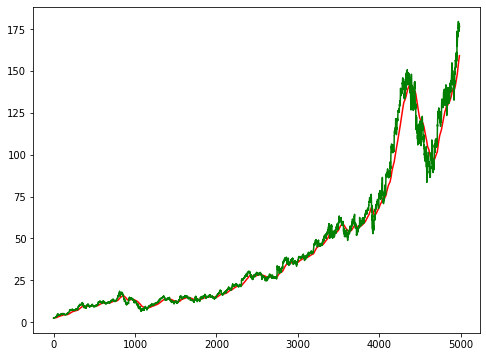

In [9]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [10]:
ma_200_days = data['Close'].ewm(span=200, adjust=False).mean()

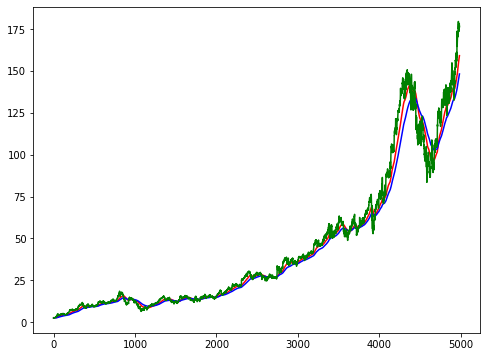

In [11]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [12]:
data.dropna(inplace=True)

In [13]:
data_train = pd.DataFrame(data.Close[0: int(len(data)* 0.8)])
data_test = pd.DataFrame(data.Close[int(len(data) * 0.80): len(data)])

In [14]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

In [15]:
# Create sequences for GRU
x = []
y = []
for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i, 0])
x, y = np.array(x), np.array(y)

In [16]:
model = Sequential()
model.add(GRU(units=50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(units=120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [18]:
model.fit(x, y, epochs=50, batch_size=32, verbose=1)


Epoch 1/50

122/122 [==============================] - 34s 163ms/step - loss: 0.0184
Epoch 2/50
122/122 [==============================] - 20s 166ms/step - loss: 0.0047
Epoch 3/50
122/122 [==============================] - 24s 198ms/step - loss: 0.0041
Epoch 4/50
122/122 [==============================] - 26s 215ms/step - loss: 0.0038
Epoch 5/50
122/122 [==============================] - 30s 245ms/step - loss: 0.0037
Epoch 6/50
122/122 [==============================] - 27s 223ms/step - loss: 0.0029
Epoch 7/50
122/122 [==============================] - 27s 223ms/step - loss: 0.0033
Epoch 8/50
122/122 [==============================] - 31s 253ms/step - loss: 0.0031
Epoch 9/50
122/122 [==============================] - 52s 427ms/step - loss: 0.0033
Epoch 10/50
122/122 [==============================] - 61s 502ms/step - loss: 0.0027
Epoch 11/50
122/122 [==============================] - 53s 431ms/step - loss: 0.0029
Epoch 12/50
122/122 [==============================] - 31s 254ms/step - l

In [23]:
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test)

In [24]:
x_test = []
y_test = []
for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

In [25]:
# Make predictions
y_pred = model.predict(x_test)

# Rescale the predictions
y_pred = scaler.inverse_transform(y_pred)

35/35 [==============================] - 1s 38ms/step


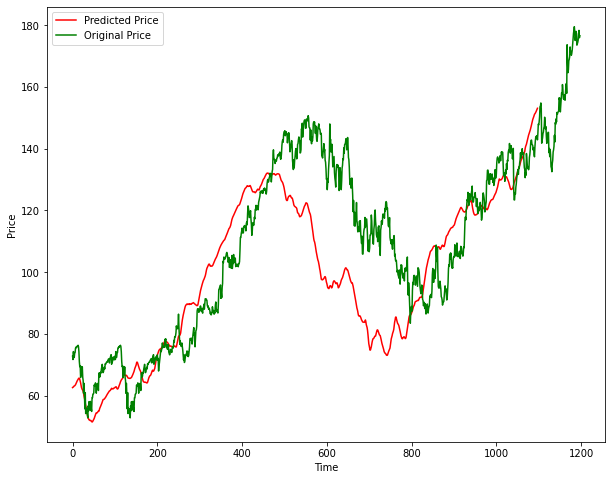

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(y_pred, 'r', label='Predicted Price')
plt.plot(data_test['Close'].values, 'g', label='Original Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [30]:
model.save("GRU_Stock_Prediction_Model.keras")
